<a href="https://colab.research.google.com/github/ljtaylor99/AAI-530-Final-Project/blob/main/AAI530_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
import glob
from datetime import datetime
import keras
import matplotlib.pyplot as plt
import os
# Setting seed for reproducibility
np.random.seed(1234)

PYTHONHASHSEED = 0
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, BatchNormalization
from keras.layers.core import Activation
from keras.utils import pad_sequences

In [13]:
paths = './*.csv'

In [14]:
# Loading all csv sheets and appending to empty DataFrame
all_data = pd.DataFrame()
for f in glob.glob(paths):
    df = pd.read_csv(f, engine='python')
    df['filename'] = f
    all_data = all_data.append(df, ignore_index=True)

In [15]:
# Checking for nulls
all_data.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
filename     0
dtype: int64

In [16]:
# Looking at Base Num with greatest amount of rides
all_data.groupby('Base').count()

,Date/Time,Lat,Lon,filename
Base,,,,
B02512,104810,104810,104810,104810
B02598,686787,686787,686787,686787
B02617,415195,415195,415195,415195
B02682,645617,645617,645617,645617
B02764,28386,28386,28386,28386


In [17]:
# Making sure Date/Time is in DateTime format
all_data['Date/Time'] = pd.to_datetime(all_data['Date/Time'])

all_data['MonthNum'] = all_data['Date/Time'].dt.month
all_data['DayNum'] = all_data['Date/Time'].dt.day
all_data['Time'] = all_data['Date/Time'].dt.time

In [18]:
all_data.groupby(['MonthNum', 'Base']).count()

Date/Time     Lat     Lon  filename  DayNum    Time
MonthNum Base                                                       
4        B02512      35536   35536   35536     35536   35536   35536
         B02598     183263  183263  183263    183263  183263  183263
         B02617     108001  108001  108001    108001  108001  108001
         B02682     227808  227808  227808    227808  227808  227808
         B02764       9908    9908    9908      9908    9908    9908
5        B02512      36765   36765   36765     36765   36765   36765
         B02598     260549  260549  260549    260549  260549  260549
         B02617     122734  122734  122734    122734  122734  122734
         B02682     222883  222883  222883    222883  222883  222883
         B02764       9504    9504    9504      9504    9504    9504
6        B02512      32509   32509   32509     32509   32509   32509
         B02598     242975  242975  242975    242975  242975  242975
         B02617     184460  184460  184460    184460  184460  184460
         B02682     194926  194926  194926    194926  194926  194926
         B02764       8974    8974    8974      8974    8974    8974

In [33]:
print(all_data.groupby(['DayNum','Base']).count())

               Date/Time   Lat   Lon  filename  MonthNum  Time  DayOfWeek
DayNum Base                                                              
1      B02598       2163  2163  2163      2163      2163  2163       2163
2      B02598       2163  2163  2163      2163      2163  2163       2163
3      B02598       2163  2163  2163      2163      2163  2163       2163
4      B02598       2163  2163  2163      2163      2163  2163       2163
5      B02598       2163  2163  2163      2163      2163  2163       2163
6      B02598       2163  2163  2163      2163      2163  2163       2163
7      B02598       2163  2163  2163      2163      2163  2163       2163
8      B02598       2163  2163  2163      2163      2163  2163       2163
9      B02598       2163  2163  2163      2163      2163  2163       2163
10     B02598       2163  2163  2163      2163      2163  2163       2163
11     B02598       2163  2163  2163      2163      2163  2163       2163
12     B02598       2163  2163  2163  

In [20]:
# Subsetting data with greatest number of rides
all_data = all_data[all_data['Base'] == 'B02598']
# Dropping Multiple Date/Time as it does not make sense for multiple lat/lon
# For each time (Multiple riders within the minute) -> Need second breakdown if
# This is possible
all_data = all_data.drop_duplicates(['Date/Time'], keep='first')

# Setting Date/Time to index -> ready to resample and forward fille
all_data = all_data.set_index(all_data['Date/Time']).drop(columns=['Date/Time'])
# Filling in missing data -> Last pick up point will stay constant until new
# Pick up point created
all_data = all_data.resample('1T').ffill()
# Subsetting for 12 hour window
all_data = all_data.between_time('08:00:00', '20:00:00')
all_data = all_data.reset_index()

all_data.head()

,Date/Time,Lat,Lon,Base,filename,MonthNum,DayNum,Time
0,2014-04-01 08:00:00,40.7747,-73.9901,B02598,./uber-raw-data-apr14.csv,4,1,08:00:00
1,2014-04-01 08:01:00,40.7356,-74.0028,B02598,./uber-raw-data-apr14.csv,4,1,08:01:00
2,2014-04-01 08:02:00,40.7156,-73.9536,B02598,./uber-raw-data-apr14.csv,4,1,08:02:00
3,2014-04-01 08:03:00,40.7595,-73.9919,B02598,./uber-raw-data-apr14.csv,4,1,08:03:00
4,2014-04-01 08:04:00,40.7319,-73.9937,B02598,./uber-raw-data-apr14.csv,4,1,08:04:00


In [21]:
# Function to get day of the week
def get_day_name(date):
    date = pd.Timestamp(date)
    return date.day_name()

In [22]:
# Using apply lambda function since casting to Timestamp is temporary
# i.e. modifying in place rather than a full cast
all_data['DayOfWeek'] = all_data['Date/Time'].apply(lambda x: get_day_name(x))

In [23]:
# Subsetting to day with most rides
fri_data = all_data[all_data['DayOfWeek']=='Friday'].reset_index(drop=True)

In [24]:
df_size = round(len(fri_data)/100)
start = np.random.choice(range(0,len(fri_data)-df_size))
df_small = fri_data.iloc[start:start+df_size].reset_index()


split_point = round(len(df_small)*0.8)
train_df = df_small.iloc[:split_point]
val_df = df_small.iloc[split_point:]

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [25]:
seq_arrays = []
seq_labs = []

seq_length = 15
ph = 1
feat_cols = ['Lon']

for start in range(0,len(train_df)-seq_length-ph):
    seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append(train_df['Lon'].iloc[start+seq_length+ph])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [26]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length,len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [27]:
model_path = 'LSTM_model1.h5'

nb_features = len(feat_cols)
nb_out = 1 
# Starting to add layers to model
model = Sequential()
model.add(Conv1D(32, input_shape=(seq_length, nb_features), kernel_size=2, activation="relu"))
model.add(BatchNormalization())
model.add(Conv1D(64, input_shape=(seq_length, nb_features), kernel_size=2, activation="relu"))
model.add(BatchNormalization())
model.add(Conv1D(128, input_shape=(seq_length, nb_features), kernel_size=2, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(input_shape=(seq_length, nb_features), units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(25, activation='linear'))
model.add(LSTM(units=25,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))

optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())
# Training to 500 epochs but will terminuate early if validation loss is not great enough
history = model.fit(seq_arrays, seq_labs, epochs=500, batch_size=8, validation_split=0.05, verbose=2, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'), keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 14, 32)            96        
                                                                 
 batch_normalization (BatchN  (None, 14, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 64)            4160      
                                                                 
 batch_normalization_1 (Batc  (None, 13, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 128)           16512     
                                                                 
 batch_normalization_2 (Batc  (None, 12, 128)          5

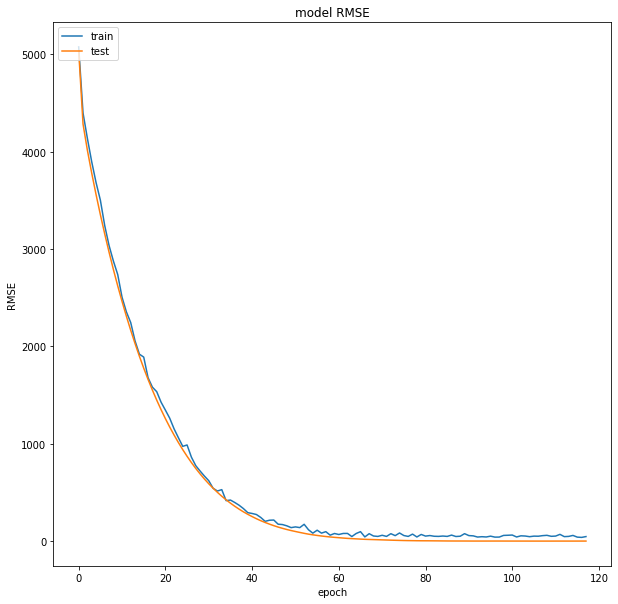

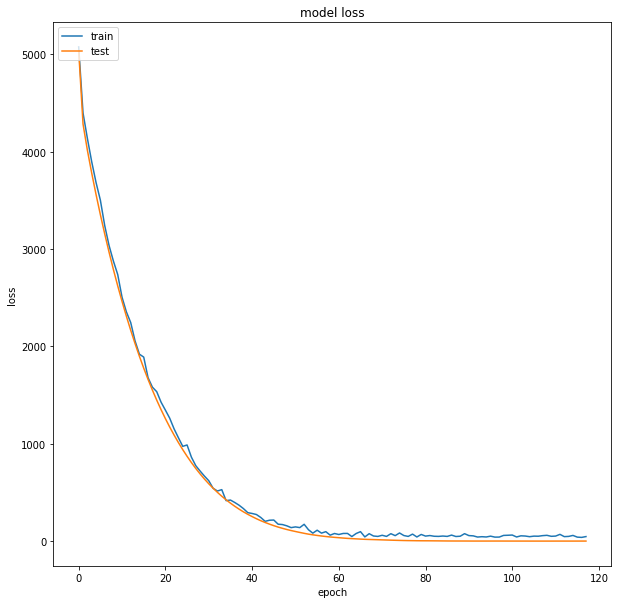

In [28]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_rmse1.png")
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

In [29]:
val_arrays = []
val_labs = []

for end in range(2, len(val_df)-ph):
#add short sequences until we reach the sequence length
  if end < seq_length:
    val_arrays.append(val_df[feat_cols][0:end].to_numpy())
    val_labs.append(val_df['Lon'][end+ph])
#add sequences of seq_length once we have enough data
  else:
    val_arrays.append(val_df[feat_cols][end-seq_length:end].to_numpy())
    val_labs.append(val_df['Lon'][end+ph])
# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = pad_sequences(val_arrays, maxlen = seq_length, dtype = np.float32)
#convert to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

1/1 - 0s - loss: 1.7809 - mse: 1.7809 - 27ms/epoch - 27ms/step

MSE: 1.7809087038040161
1/1 [==============================] - 1s 929ms/step


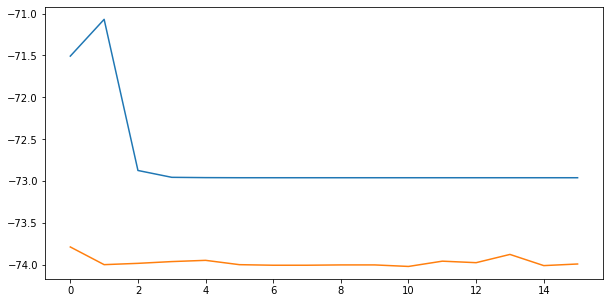

In [30]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)
# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')